# this might be a good notebook for building and storing images

In [34]:
%matplotlib inline
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import pickle
import h5py

# upload the data

In [35]:
positron = uproot.open("/mnt/Storage/fmanzali/FlatComplete/eplus_hits_dn_0.root")
electron = uproot.open("/mnt/Storage/gvicentini/ElectronDataset/Hits/eminus_hits_dn_0.root")
posPMT = positron["lpmt_hits"]
elPMT = electron['lpmt_hits']

In [36]:
PMT_pos = electron["lpmt_pos"]
PMT_pos_pd = PMT_pos.pandas.df()

# select the events in the defined region (15,5 < R < 16,5)

In [47]:
posINFO = positron["true_info"]
posINFO_pd = trueINFO.pandas.df()
elINFO = electron["true_info"]
elINFO_pd = elINFO.pandas.df()

def filt_pos(frame):

    new_frame = frame.loc[(frame['R'] < 16500) & (frame['R'] > 15500)]
    return new_frame

posR = filt_pos(posINFO_pd)
elR = filt_pos(elINFO_pd)

# here a list of functions to manipulate the data

# remove the dark noise

In [38]:
def no_DN (frame):
    
    i = frame.index[0][0]
    new_frame = frame.loc[(frame['isDN'].values == False) & (frame['hitTime'].values < 300)]
    return new_frame.loc[i]

# take only the first hit time

In [39]:
def first (frame):
    frame_sort = frame.sort_values(['hitTime'])
    frame_first = frame_sort.drop_duplicates(subset='pmtID', keep='first')
    frame_last = frame_first.sort_values('hitTime', ascending=False)
    return frame_last

# translate the offset so that the first hit pmt is hit at 0 s

In [40]:
def normal_ft(ev):
    
    #data = []
    #ma = ev['hitTime'].max()
    mi = ev['hitTime'].min()
    #mami = ma - mi
    
    a = ev['nHits'].values
    b = ev['pmtID'].values
    c = ev['hitTime'] - mi
    data = {'nHits': a, 'pmtID': b, 'hitTime': c}
        
    norm = pd.DataFrame(data)
    return norm

# build new dataframes whit pmtID, pmt_pos and first hit time as entries

In [41]:
def mapev (ev):
    
    x = PMT_pos_pd['pmt_x']
    y = PMT_pos_pd['pmt_y']
    z = PMT_pos_pd['pmt_z']
    
    i = ev['pmtID'].values
    xs = x[ev['pmtID']]
    ys = y[ev['pmtID']]
    zs = z[ev['pmtID']] 
    t = ev['hitTime'].values
    data ={'pmtID': i, 'pmt_x': xs, 'pmt_y': ys, 'pmt_z':zs, 'hitTime': t}
    
    ev_map = pd.DataFrame(data)
    return ev_map

# make the images and save them to the disk (pmts not affected are arbitraly associated with 1024)

In [42]:
def mollweide (ev_map, j):
    # Set the coordinates for the input
    nside = 16
    npix = hp.nside2npix(nside)

    # Coordinates and the density field f
    hitTime = ev_map['hitTime']
    x = ev_map['pmt_x']
    y = ev_map['pmt_y']
    z = ev_map['pmt_z']
    
    # Go from HEALPix coordinates to indices
    indices = hp.vec2pix(nside, x, y, z)

    # Initate the map and fill it with the values
    hpxmap = np.full(npix, 1024, dtype=np.float)
    hpxmap[[indices]]  = hitTime
   
    # Inspect the map
    project = hp.mollview(hpxmap, title=None, cbar=False, return_projected_map=True)
    #plt.savefig('/mnt/Storage/gvicentini/electron0/ev'+str(j)+'.png')
    return project

In [12]:
def HDF5 (proj, i):
    h5f = h5py.File('/mnt/Storage/gvicentini/data.h5', 'a')   
    h5f.create_dataset('dataset_'+str(i), data=proj)
    h5f.close()

# loop all the func for all the selected events

In [43]:
def save_image(file, info):
    
    #j = 0
    for i in info['evtID']:
        #project = None
        #j += 1
        ev = file.pandas.df(entrystart=i, entrystop=i+1)
        ev_noDN = no_DN(ev)
        ev_first = first(ev_noDN)
        ev_norm = normal_ft(ev_first)
        ev_map = mapev(ev_norm)
        project = mollweide(ev_map, i)
        #HDF5 (project, j) 

# sample for positrons

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


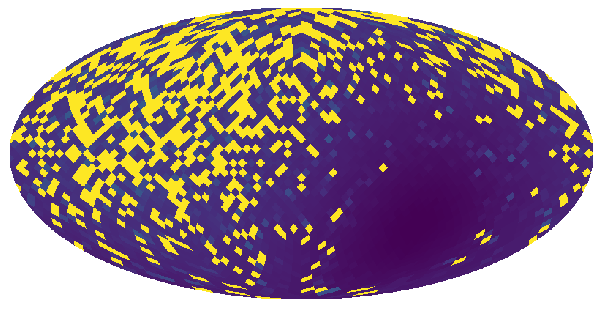

In [44]:
i=6
ev = posPMT.pandas.df(entrystart=i, entrystop=i+1)
ev_noDN = no_DN(ev)
ev_first = first(ev_noDN)
ev_norm = normal_ft(ev_first)
ev_map = mapev(ev_norm)
project = mollweide(ev_map, i)
#png(project, i)
#plt.savefig('ev'+str(i)+'.png')

# sample for electrons

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


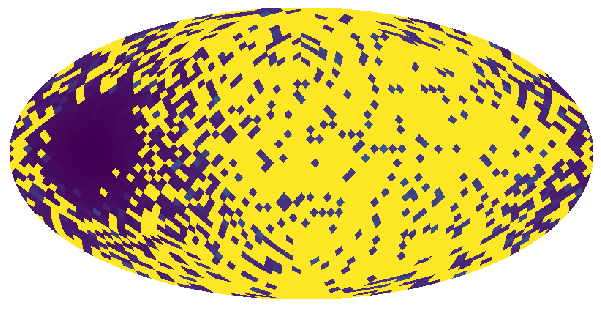

In [48]:
i=15
ev = elPMT.pandas.df(entrystart=i, entrystop=i+1)
ev_noDN = no_DN(ev)
ev_first = first(ev_noDN)
ev_norm = normal_ft(ev_first)
ev_map = mapev(ev_norm)
project = mollweide(ev_map, i)

# after storing we can recover them through the path

(-0.5, 611.5, 387.5, -0.5)

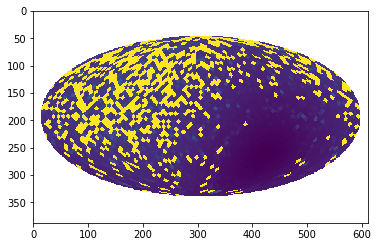

In [49]:
import matplotlib.image as mpimg
img=mpimg.imread("/mnt/Storage/gvicentini/positron0/ev6.png")
a=plt.imshow(img)
#plt.show()
a.get_extent()

(-0.5, 611.5, 387.5, -0.5)

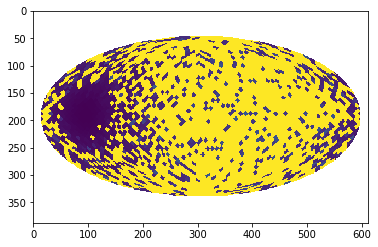

In [50]:
import matplotlib.image as mpimg
img=mpimg.imread("/mnt/Storage/gvicentini/electron0/ev15.png")
a = plt.imshow(img)
#plt.show()
a.get_extent()

In [32]:
img.shape

(388, 612, 4)

In [ ]:
save_image(posPMT, posR)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/healpy/visufunc.py:186: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = pylab.figure(fig, figsize=(8.5, 5.4))


In [23]:
h5f = h5py.File('data.h5','r')
h5f.close()

In [17]:
project

masked_array(
  data=[[-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        ...,
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf]],
  mask=False,
  fill_value=-1.6375e+30)